In [1]:
import gym
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [21]:
env = gym.make('Asterix-ram-v0')
n_episodes = 100
max_step = 2000
eps = 0.001

In [25]:
device = 'cuda:0'
policy_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 9),
                    nn.Softmax()
                    )
policy_net.to(device)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=3e-3)
policy_scheduler = torch.optim.lr_scheduler.StepLR(policy_optimizer, 5, gamma=0.95)

value_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 1)
                    )
value_net.to(device)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=3e-3)
value_scheduler = torch.optim.lr_scheduler.StepLR(value_optimizer, 5, gamma=0.95)

In [26]:
total_rewards = []
freq = max(n_episodes // 20, 1)

In [28]:
for episode in range(n_episodes):
    logs = []
    rewards = []
    values = []
    state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
    for step in range(max_step):
        policy = policy_net(state)
        action = np.random.choice(np.arange(9), p=policy.cpu().detach().numpy())
        log = torch.log(policy[action] + 1e-6)
        #print(log)
        logs.append(log)
        value = value_net(state)
        values.append(value)
        state, reward, done, info = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        
        rewards.append(reward)
        if done:
            break
    T = len(rewards)
    #print(rewards[-1])
    rewards = np.array(rewards)
    total_rewards.append(rewards.sum())
    
    G = []
    for t in range(T):
        g = rewards[t:].sum() - values[t].cpu().detach().numpy()[0]
        G.append(g)
        
    log_grads = 0
    for log, g in zip(logs, G):
        log_grads -= g * log
        
    value_grads = 0
    for value, g in zip(values, G):
        value_grads -= g * value
    
    policy_optimizer.zero_grad()
    log_grads.to(device).backward(retain_graph=True)
    policy_optimizer.step()
    policy_scheduler.step()
    
    value_optimizer.zero_grad()
    value_grads.to(device).backward()
    value_optimizer.step()
    value_scheduler.step()
    
    if not episode % freq:
        print('Episode: {}/{} || Reward: {}  Steps: {}'.format(episode, n_episodes, total_rewards[-1], T))
        print('log grad:', log_grads)
        print('value grad', value_grads, end='\n\n')

Episode: 0/100 || Reward: 50.0  Steps: 293
log grad: tensor(319.3661, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-698.2320], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 5/100 || Reward: 200.0  Steps: 757
log grad: tensor(0.0198, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([2129123.5000], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 10/100 || Reward: 200.0  Steps: 768
log grad: tensor(0.0307, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([3717976.], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 15/100 || Reward: 200.0  Steps: 762
log grad: tensor(0.0167, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([1648764.5000], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 20/100 || Reward: 200.0  Steps: 761
log grad: tensor(-0.0057, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-510225.4688], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 25/100 || Reward: 200.0  Steps: 772
log grad: tensor(-0.0133, d

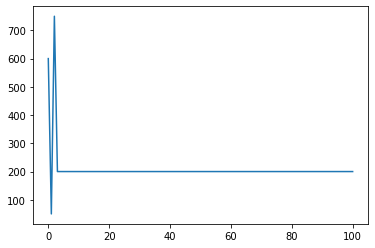

In [29]:
plt.plot(total_rewards)